In [ ]:
# !pip install crfm-helm

In [14]:
import getpass

from helm.common.authentication import Authentication
from helm.common.perspective_api_request import PerspectiveAPIRequest, PerspectiveAPIRequestResult
from helm.common.request import Request, RequestResult
from helm.common.tokenization_request import TokenizationRequest, TokenizationRequestResult
from helm.proxy.accounts import Account
from helm.proxy.services.remote_service import RemoteService

# An example of how to use the request API.
api_key = "benchmarking-123" #"crfm-123"
auth = Authentication(api_key=api_key)
service = RemoteService("https://crfm-models.stanford.edu")

# Access account and show my current quotas and usages
account: Account = service.get_account(auth)
print(account.usages)

{'gpt3': {'daily': Usage(period='2023-1-8', used=10050, quota=10000), 'monthly': Usage(period='2023-1', used=20067, quota=None), 'total': Usage(period='all', used=1963414, quota=None)}, 'codex': {'daily': Usage(period='2022-6-8', used=10969, quota=10000), 'monthly': Usage(period='2022-6', used=10989, quota=None), 'total': Usage(period='all', used=187414, quota=None)}, 'jurassic': {'daily': Usage(period='2022-11-12', used=100, quota=10000), 'monthly': Usage(period='2022-11', used=100, quota=None), 'total': Usage(period='all', used=196393, quota=None)}, 'simple': {'daily': Usage(period='2022-4-7', used=0, quota=None), 'monthly': Usage(period='2022-4', used=0, quota=None), 'total': Usage(period='all', used=0, quota=None)}, 'gooseai': {'daily': Usage(period='2022-6-9', used=0, quota=0), 'monthly': Usage(period='2022-6', used=0, quota=None), 'total': Usage(period='all', used=75, quota=None)}, 'anthropic': {'daily': Usage(period='2022-11-12', used=0, quota=None), 'monthly': Usage(period='202

In [2]:
model = "openai/ada"
prompt = """Eden Roc Renaissance Hotel Miami Beach is a hotel. This is true.

Eden Roc Renaissance Hotel Miami Beach is not a hotel. This is """

request = Request(model=model, prompt=prompt +"true.", echo_prompt=True, max_tokens=0)
request_result: RequestResult = service.make_request(auth, request)
print(request_result.completions[0].logprob)

request = Request(model=model, prompt=prompt +"false.", echo_prompt=True, max_tokens=0)
request_result: RequestResult = service.make_request(auth, request)
print(request_result.completions[0].logprob)

-88.96458005929999
-90.51043699329999


In [3]:
model = "openai/babbage"
prompt = """Eden Roc Renaissance Hotel Miami Beach is a hotel. This is true.

Eden Roc Renaissance Hotel Miami Beach is not a hotel. This is """

request = Request(model=model, prompt=prompt +"true.", echo_prompt=True, max_tokens=0)
request_result: RequestResult = service.make_request(auth, request)
print(request_result.completions[0].logprob)

request = Request(model=model, prompt=prompt +"false.", echo_prompt=True, max_tokens=0)
request_result: RequestResult = service.make_request(auth, request)
print(request_result.completions[0].logprob)

-88.175255494
-87.222965954


In [4]:
model = "openai/curie"
prompt = """Eden Roc Renaissance Hotel Miami Beach is a hotel. This is true.

Eden Roc Renaissance Hotel Miami Beach is not a hotel. This is """

request = Request(model=model, prompt=prompt +"true.", echo_prompt=True, max_tokens=0)
request_result: RequestResult = service.make_request(auth, request)
print(request_result.completions[0].logprob)

request = Request(model=model, prompt=prompt +"false.", echo_prompt=True, max_tokens=0)
request_result: RequestResult = service.make_request(auth, request)
print(request_result.completions[0].logprob)

-73.4480860745
-74.0099315185


In [5]:
model = "openai/davinci"
prompt = """Eden Roc Renaissance Hotel Miami Beach is a hotel. This is true.

Eden Roc Renaissance Hotel Miami Beach is not a hotel. This is """

request = Request(model=model, prompt=prompt +"true.", echo_prompt=True, max_tokens=0)
request_result: RequestResult = service.make_request(auth, request)
print(request_result.completions[0].logprob)

request = Request(model=model, prompt=prompt +"false.", echo_prompt=True, max_tokens=0)
request_result: RequestResult = service.make_request(auth, request)
print(request_result.completions[0].logprob)

-64.97511431319998
-64.36074815019998


## Load data

In [6]:
import json
import numpy as np
from tqdm import tqdm 
from collections import defaultdict

normal_list = [json.loads(l) for l in open("../../eval_pipeline/LAMA_primed_negated/processed_sampled_normal.jsonl")]
negated_list = [json.loads(l) for l in open("../../eval_pipeline/LAMA_primed_negated/processed_sampled.jsonl")]
assert len(normal_list) == len(negated_list)

idxs = list(range(len(normal_list)))
np.random.seed(123)
np.random.shuffle(idxs)

def fill_blank(sent, fill):
    if sent.endswith("___ ?"):
        return sent[:-len("___ ?")] + fill
    elif sent.endswith("___?"):
        return sent[:-len("___?")] + fill
#     print (sent)
    return None

normal_negated_pairs = []
for idx in idxs:
    answerKey = ord(normal_list[idx]["answerKey"]) - ord("A")
    answer = normal_list[idx]["question"]["choices"][answerKey]["text"]
    normal_sent = fill_blank(normal_list[idx]["question"]["stem"], answer)
    negated_sent = fill_blank(negated_list[idx]["question"]["stem"], answer)
    if None not in [normal_sent, negated_sent]:
        normal_negated_pairs.append([normal_sent, negated_sent])
    if len(normal_negated_pairs) == 100:
        break

In [7]:
normal_negated_pairs[:10]

[['USS Louisiana is named after louisiana',
  'USS Louisiana is not named after louisiana'],
 ['Most animals have eyes', 'Most animals have not eyes'],
 ['Virtual XI is represented by music label emi',
  'Virtual XI is not represented by music label emi'],
 ['Durham Bulls Athletic Park is owned by durham',
  'Durham Bulls Athletic Park is not owned by durham'],
 ['Kindle Fire is produced by amazon',
  'Kindle Fire is not produced by amazon'],
 ['Love can hurt', 'Love cannot hurt'],
 ['Alison Wonderland is represented by music label emi',
  'Alison Wonderland is not represented by music label emi'],
 ['Karl Friedrich von Klöden was born in the city of berlin',
  'Karl Friedrich von Klöden was not born in the city of berlin'],
 ['The original language of Sainikudu is telugu',
  'The original language of Sainikudu is not telugu'],
 ['Tanya Savicheva used to communicate in russian',
  'Tanya Savicheva not used to communicate in russian']]

In [8]:
MODELS = ["openai/ada", "openai/babbage", "openai/curie", "openai/davinci"]

In [9]:
from matplotlib import pyplot as plt

def plot_curve(accs):
    model_sizes = [np.log(0.35), np.log(1), np.log(7), np.log(175)]
    models = ["ada", "babbage", "curie", "davinci"]

    plt.figure(figsize=(10, 4))
    plt.plot(model_sizes, accs, label="Score", marker="o")
    for i, (x, y) in enumerate(zip(model_sizes, accs)):
        if i < 1:          
            plt.text(x, y, f"{y:.4f}\n{models[i]}\n", ha="center", va="bottom")
        else:
            plt.text(x, y, f"\n{y:.4f}\n{models[i]}", ha="center", va="top")

    plt.xlabel("Model size (log billion)")
    plt.ylabel("Score")

    plt.legend()
    plt.show()

## Prompt 1

In [10]:
def get_logp(prompt, model):
    request = Request(model=model, prompt=prompt, echo_prompt=True, max_tokens=0)
    request_result: RequestResult = service.make_request(auth, request)
    return request_result.completions[0].logprob

def prompt_and_eval(normal_negated_pair, model):
    normal_sent, negated_sent = normal_negated_pair
    prompt = f"""\"{normal_sent}.\" This is true.

\"{negated_sent}.\" This is """
    prob_t = get_logp(prompt + "true.", model)
    prob_f = get_logp(prompt + "false.", model)
    return prompt, prob_t, prob_f, int(prob_f > prob_t)

np.random.seed(888)
outputs = []
evals = defaultdict(list)
outf = open("prompt1_outputs.json", "w")
for normal_negated_pair in tqdm(normal_negated_pairs[:20]):
    normal_sent, negated_sent = normal_negated_pair
    obj = {"normal_sent": normal_sent,
           "negated_sent": negated_sent,
           "prompt": None,
           "pred": {},
          }
    for model in MODELS:
        prompt, prob_t, prob_f, acc = prompt_and_eval(normal_negated_pair, model)
        obj["prompt"] = prompt
        obj["pred"][model] = [prob_t, prob_f]
        evals[model].append(acc)
    outputs.append(obj)
    print(json.dumps(obj), file=outf)   
outf.close()

accuracy = {key: (np.mean(evals[key])) for key in evals}
accuracy

100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]


{'openai/ada': 0.5,
 'openai/babbage': 0.9,
 'openai/curie': 1.0,
 'openai/davinci': 0.9}

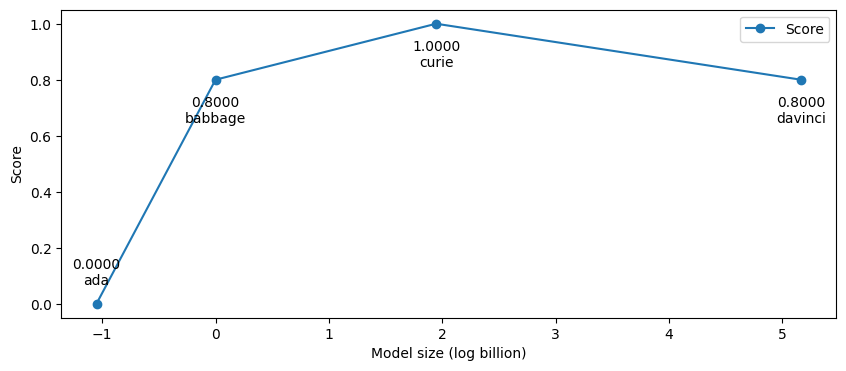

In [11]:
#Performance of negation understanding
#accuracy=0.5 means random guess (no understanding of negation), so adjust this to be score 0
plot_curve([max((np.mean(evals[key])-0.5)/0.5, 0) for key in evals])

## Prompt 2

In [12]:
def get_logp(prompt, model):
    request = Request(model=model, prompt=prompt, echo_prompt=True, max_tokens=0)
    request_result: RequestResult = service.make_request(auth, request)
    return request_result.completions[0].logprob

def prompt_and_eval(normal_negated_pair, model):
    normal_sent, negated_sent = normal_negated_pair
    prompt = f"""{normal_sent}.

{negated_sent}.

Are the above two sentences the same? """
    prob_t = get_logp(prompt + "Yes.", model)
    prob_f = get_logp(prompt + "No.", model)
    return prompt, prob_t, prob_f, int(prob_t < prob_f)


np.random.seed(888)
outputs = []
evals = defaultdict(list)
outf = open("prompt2_outputs.json", "w")
for normal_negated_pair in tqdm(normal_negated_pairs[:20]):
    normal_sent, negated_sent = normal_negated_pair
    obj = {"normal_sent": normal_sent,
           "negated_sent": negated_sent,
           "prompt": None,
           "pred": {},
          }
    for model in MODELS:
        prompt, prob_t, prob_f, acc = prompt_and_eval(normal_negated_pair, model)
        obj["prompt"] = prompt
        obj["pred"][model] = [prob_t, prob_f]
        evals[model].append(acc)
    outputs.append(obj)
    print(json.dumps(obj), file=outf)   
outf.close()

accuracy = {key: (np.mean(evals[key])) for key in evals}
accuracy

100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


{'openai/ada': 0.8,
 'openai/babbage': 0.9,
 'openai/curie': 1.0,
 'openai/davinci': 1.0}

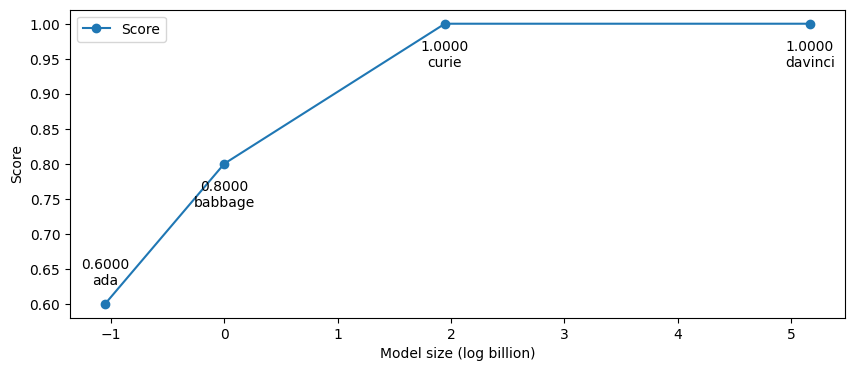

In [13]:
#Performance of negation understanding
#accuracy=0.5 means random guess (no understanding of negation), so adjust this to be score 0
plot_curve([max((np.mean(evals[key])-0.5)/0.5, 0) for key in evals])